# Week 6 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [217]:
noise = .2
#
#1 random with noise = .2
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.random())
#2 andsplit noise = .2
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(noise))
#3 xorSplit noise = .2
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(noise)) #Please try this one
#4 targetSplit noise = .2
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(noise))
#5 multiBlobs noise = .2
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(noise))
#6 multibBlobs noise = .7
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(.7))
#7 targetSplit noise = .7
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(.7))
#8 xorSplit noise = .7
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(.7))
#9 andSplit noise=.7
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(.7))
#10 andSplit noise=.4
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(.4))

We can easily visualize the rendered datasets because they are generated in two dimensions.

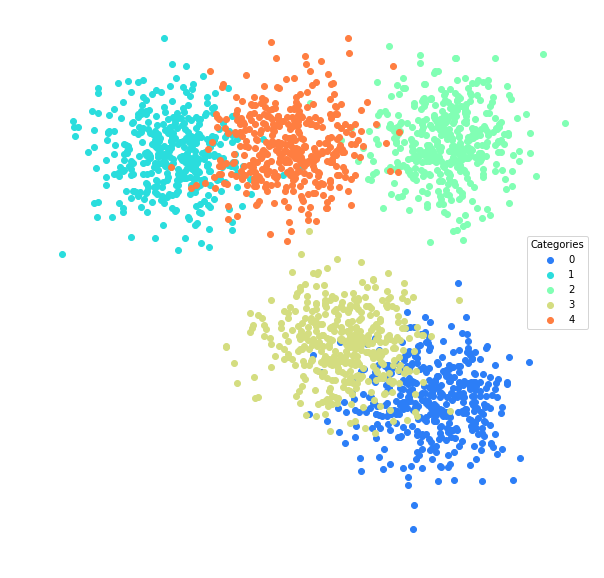

In [218]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [225]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [226]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB(priors=None)

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [227]:
lucem_illud.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.925894,0.799092,0.050,0.876190,0.884615
1,0.964452,0.881542,0.030,0.913043,0.954545
2,0.991708,0.967253,0.006,0.976744,0.988235
3,0.915366,0.774013,0.050,0.869565,0.860215
4,0.936791,0.860601,0.036,0.941176,0.888889


This lets us look at which classes do better:

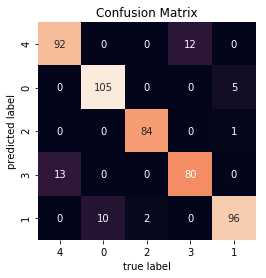

In [228]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

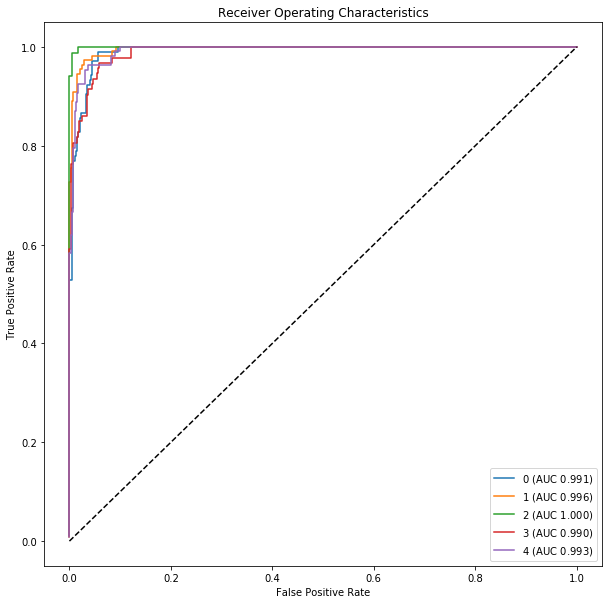

In [229]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

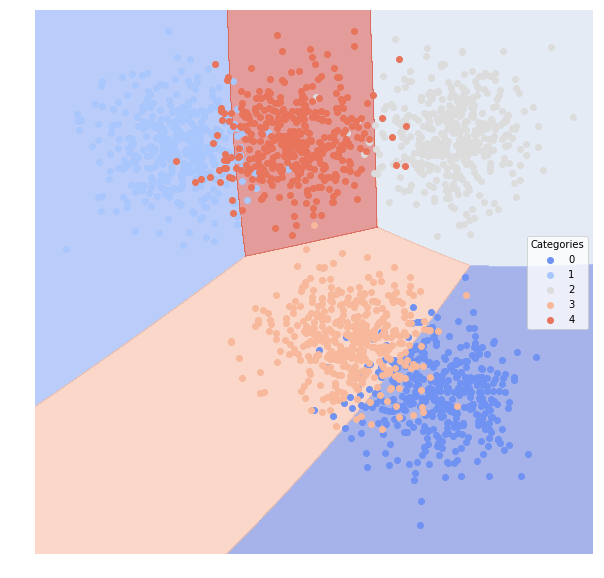

In [230]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [395]:
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadReddit())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadNewsGroups())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateSmall())
#dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateLarge())
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadSpam())

Loading Spam
Loading Ham
Converting to vectors


In [438]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()

In [439]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [440]:
lucem_illud.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
not spam,0.630613,0.891211,0.109649,0.891437,0.993186
spam,0.630613,0.336104,0.109649,0.866667,0.268041


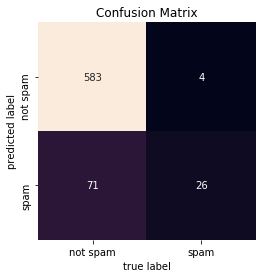

In [441]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

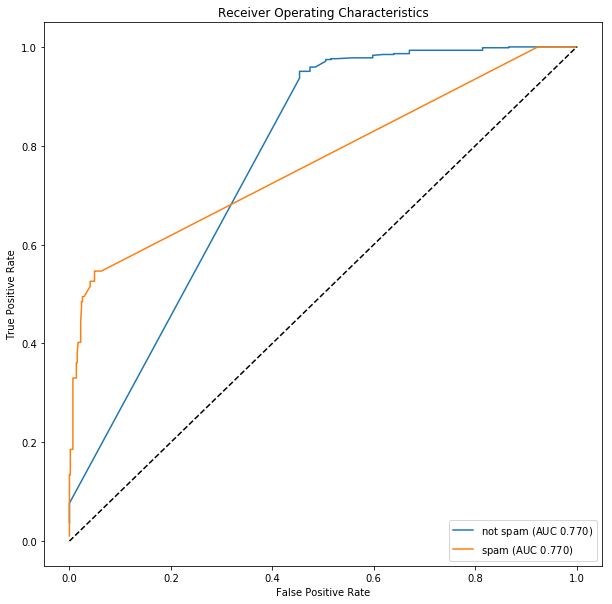

In [442]:
lucem_illud.plotMultiROC(clf, dfTest)

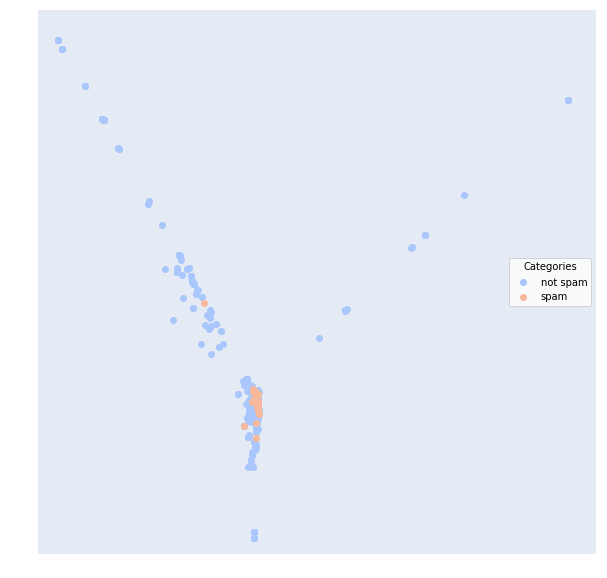

In [443]:
lucem_illud.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

With the random artificial data, obviously all the algorithims performed poorly in classifying the data.

The XorSplit data is interesting in that Bayes does not classify it well. This happens because the two variables describing the data interact in a way that the bayes algorithm cannot detect. The same issue occured with classical regression. The neural network and gradient boost algorithms were much better at classifying the xorSplit data because they are designed to optimize these groupings.

The gradient boost algorithm, neural network algorithm, and random forest algorithm do an excellent job at classifying the randomly located gaussian distributions because they optimize the groupings while minimizing distances between the datapoints. 


The reddit data is classified very well with the neural network algorithm because it is a social network and users interact with other users based on their interests, therefore the algorithm can exploit this link.

Support Vector Classification performed very poorly for the news topics. Meanwhile, the logistic regression performed well along with the gradient boost (ensemble) algorithm. SVC performed poorly because of an issue with overfitting in the model.

For the small senator data, gradient boosting (ensemble) algorithm performed well, as did neural network, decision tree, random forest, and logistic regression. However, the 'poly' SVC algorithim again performed poorly because it overfitted the data and indicated that clinton was the only senator in the dataset. Bayes also did not perform well, likely for the same reason that it failed in the artificial dataset xorsplit.

For the larger senator data, bayes similarly performed poorly. However, the SVC linear alogrithm performed well, likely because the larger number of senators (while using the linear model) prevented overfitting. Logistic regresion performs well, however the decision tree and random forest models indicate their classification regions to be incorrect (while their statistics perform well). The neural network performs well. Gradient Boosting performed very well.

For the Spam/Not Spam data, bayes performed moderately well. Linear SVC is similar, note that they do a poor job with classifying spam as spam. 'Poly' SVC overfits the model; it considers all emails to not be spam. Gradient descent is also very poor.


## Stretch

In [444]:
#artificial dataset for study is xor split with noise of .2
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(.2))


In [446]:
clf = sklearn.ensemble.AdaBoostClassifier(n_estimators=100)

In [447]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [448]:
lucem_illud.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.455596,0.474578,0.545,0.455357,0.515152
1,0.455596,0.485018,0.545,0.454545,0.396040


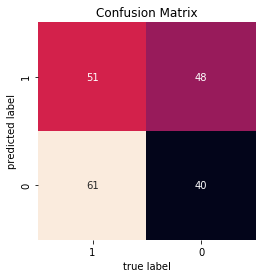

In [449]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

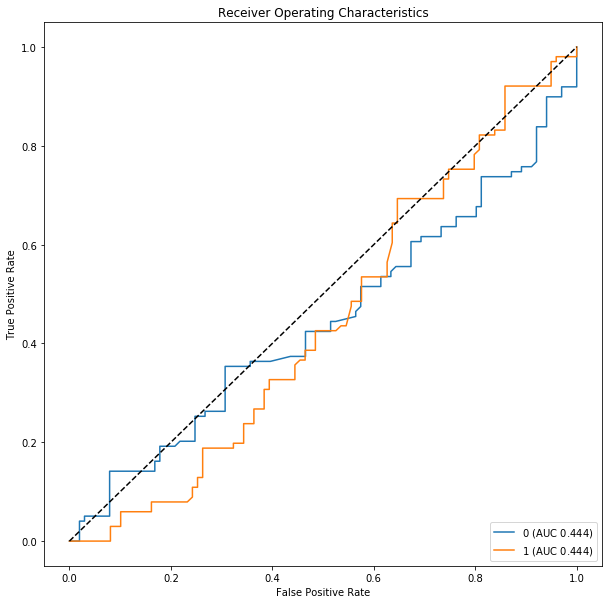

In [450]:
lucem_illud.plotMultiROC(clf, dfTest)

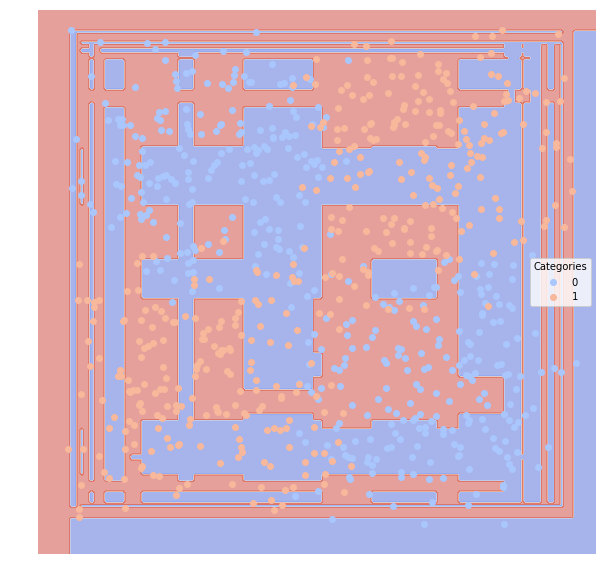

In [451]:
lucem_illud.plotregions(clf, dfTrain)

In [452]:
#real dataset for study is reddit threads classified by topics
dfTrain, dfTest = lucem_illud.trainTestSplit(lucem_illud.loadReddit())


Loading Reddit data
Converting to vectors


In [453]:
clf = sklearn.ensemble.AdaBoostClassifier(n_estimators=100)

In [454]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [455]:
lucem_illud.evaluateClassifier(clf, dfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Relationships,0.842411,0.611022,0.137931,0.698925,0.802469
Bad Roommates,0.835498,0.679722,0.115987,0.831169,0.727273
Tales From Tech Support,0.900329,0.704974,0.084639,0.775000,0.873239
Weeaboo Tales,0.928296,0.882767,0.037618,0.985507,0.860759


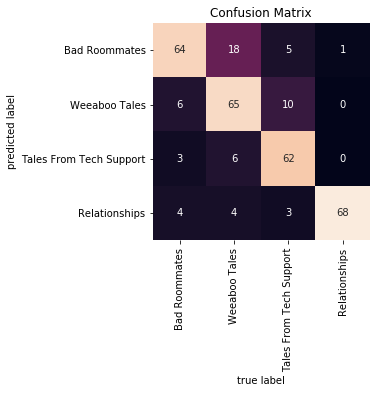

In [456]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

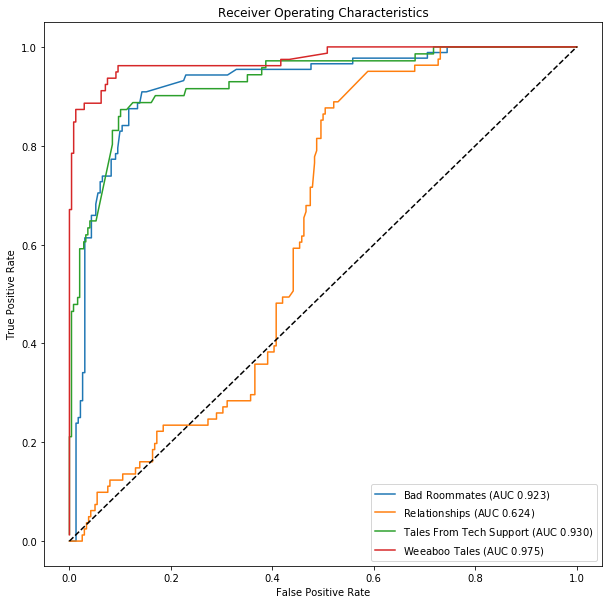

In [457]:
lucem_illud.plotMultiROC(clf, dfTest)

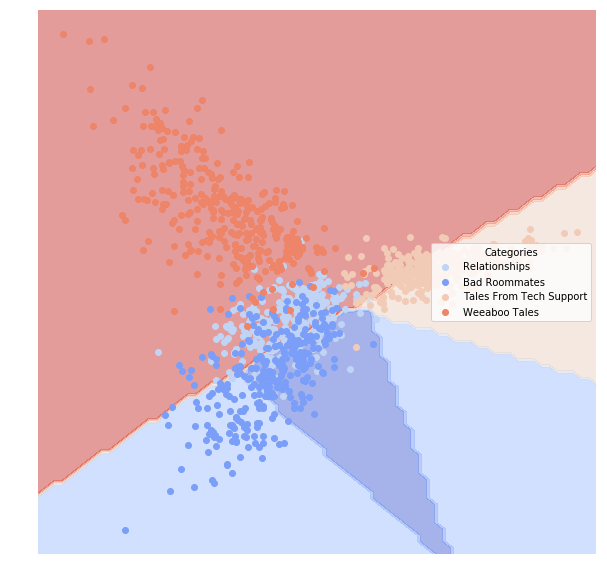

In [458]:
lucem_illud.plotregions(clf, dfTrain)

I used the AdaBoost algorithm, which is a boosting ensemble method. Ensemble methods use several base estimator predictions with a learning algorithm to build robustness over a single estimator. Boosting retools these algorithms by running them sequentially to reduce the bias of the estimator. AdaBoost specifically is designed for weak learning sequences by running these models on repeatedly modified versions of the data. It performed well for the reddit dataset (real data), likely because as weights are updated in AdaBoost, they force the model to focus on data not yet classificed. This is the same reason it likely failed for the artificial (xor) dataset; this grouping adversely affected the weighting designed in the algorithm.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [459]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

Let's turn the 'targetSenator' column into a binary category variable.

In [460]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [461]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: nltk.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

Let's split the data into training data and testing data.

In [462]:
ObamaClintonReleases.head()

,download_url,html_url,name,path,text,targetSenator,category,tokenized_text,normalized_text
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama,True,"[Obama, Calls, on, IRS, to, Protect, Taxpayers...","[obama, call, ir, protect, taxpay, privaci, u,..."
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama,True,"[Statement, from, Senator, Barack, Obama, on, ...","[statement, senat, barack, obama, dodd, shelbi..."
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama,True,"[Obama, Says, Bill, Will, Help, Cut, Off, Supp...","[obama, say, bill, help, cut, suppli, danger, ..."
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama,True,"[Obama, Durbin, Say, Illinois, Will, Receive, ...","[obama, durbin, say, illinoi, receiv, percent,..."
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama,True,"[Obama, Introduces, Bill, to, Help, Tap, Power...","[obama, introduc, bill, help, tap, power, geno..."


In [463]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [465]:
train_data_df.head()

,download_url,html_url,name,path,text,targetSenator,category,tokenized_text,normalized_text
1451,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,18Dec2006Clinton4.txt,raw/Clinton/18Dec2006Clinton4.txt,December 18 2006 Senator Clinton Reps Malon...,Clinton,False,"[December, 18, 2006, Senator, Clinton, Reps, M...","[decemb, senat, clinton, rep, maloney, fossell..."
1144,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,14Sep2005Clinton262.txt,raw/Clinton/14Sep2005Clinton262.txt,September 14 2005 Statement of Senator Hillar...,Clinton,False,"[September, 14, 2005, Statement, of, Senator, ...","[septemb, statement, senat, hillari, rodham, c..."
905,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,12Mar2007Clinton989.txt,raw/Clinton/12Mar2007Clinton989.txt,March 12 2007 Senator Clinton Calls for Inves...,Clinton,False,"[March, 12, 2007, Senator, Clinton, Calls, for...","[march, senat, clinton, call, investig, new, y..."
1538,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,19Dec2005Clinton19.txt,raw/Clinton/19Dec2005Clinton19.txt,December 19 2005 Schumer Clinton Congressio...,Clinton,False,"[December, 19, 2005, Schumer, Clinton, Congres...","[decemb, schumer, clinton, congression, panel,..."
965,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Dec2007Clinton103.txt,raw/Clinton/13Dec2007Clinton103.txt,December 13 2007 Statement of Senator Clinton...,Clinton,False,"[December, 13, 2007, Statement, of, Senator, C...","[decemb, statement, senat, clinton, passag, en..."


In [466]:
test_data_df.head()

,download_url,html_url,name,path,text,targetSenator,category,tokenized_text,normalized_text
1038,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Nov2007Clinton167.txt,raw/Clinton/13Nov2007Clinton167.txt,November 13 2007 Senator Clinton Introduces L...,Clinton,False,"[November, 13, 2007, Senator, Clinton, Introdu...","[novemb, senat, clinton, introduc, legisl, pro..."
954,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Apr2005Clinton597.txt,raw/Clinton/13Apr2005Clinton597.txt,April 13 2005 Schumer Clinton Key Senate Pa...,Clinton,False,"[April, 13, 2005, Schumer, Clinton, Key, Senat...","[april, schumer, clinton, key, senat, panel, a..."
1180,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Jun2005Clinton460.txt,raw/Clinton/15Jun2005Clinton460.txt,June 15 2005 Prepared Floor Statement by Sena...,Clinton,False,"[June, 15, 2005, Prepared, Floor, Statement, b...","[june, prepar, floor, statement, senat, hillar..."
319,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,22Jun2007Obama359.txt,raw/Obama/22Jun2007Obama359.txt,Obama Applauds Modest First Step on Fuel Ec...,Obama,True,"[Obama, Applauds, Modest, First, Step, on, Fue...","[obama, applaud, modest, first, step, fuel, ec..."
1121,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,14Jun2007Clinton701.txt,raw/Clinton/14Jun2007Clinton701.txt,June 14 2007 Statement of Senator Hillary Rod...,Clinton,False,"[June, 14, 2007, Statement, of, Senator, Hilla...","[june, statement, senat, hillari, rodham, clin..."


In [464]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [467]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [468]:
TFVects.shape

(1368, 11278)

We can save this in the dataframe to make things easier

In [469]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [470]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [471]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

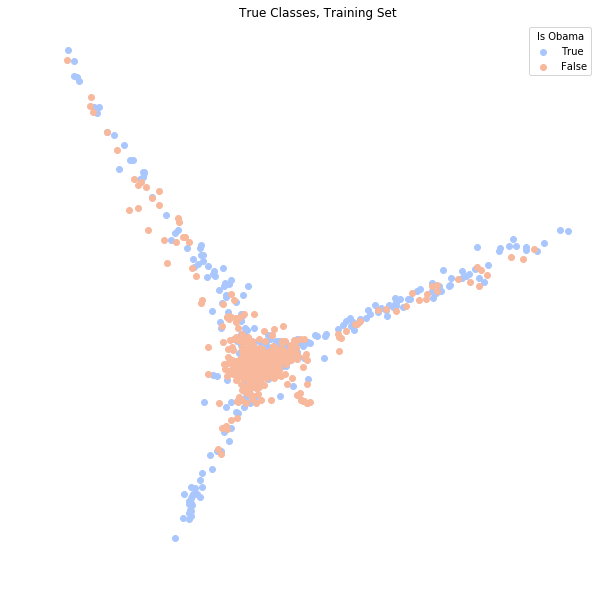

In [472]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

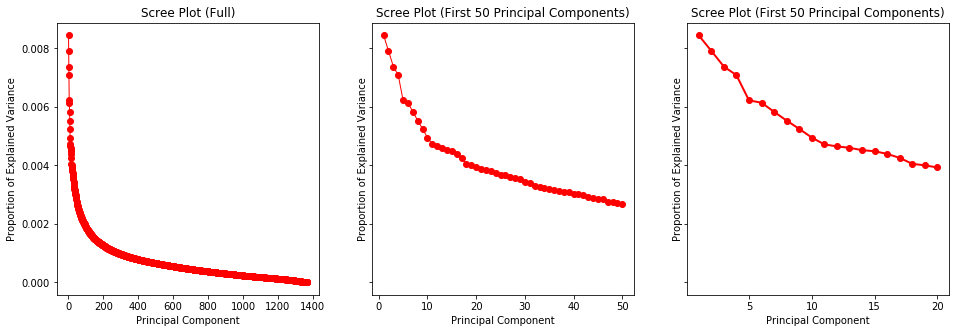

In [473]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [474]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [475]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [476]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.668859649122807

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [477]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6744868035190615

Slightly poorer. How about using more dimensions (40)?

In [478]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7551169590643275
Testing:
0.7096774193548387


Or still more (100)?

In [479]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8223684210526315
Testing:
0.7741935483870968


Or even more (200)!

In [480]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8757309941520468
Testing:
0.8093841642228738


This is becoming ridiculous (400)!

In [481]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9115497076023392
Testing:
0.8269794721407625


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [482]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.810672514619883


Train the model using training data, and then test it on the testing data.

In [483]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.7595307917888563


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [484]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [485]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9451754385964912
Testing:
0.8357771260997068


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [486]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [487]:
sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['category'])

0.7441860465116279

Recall:

In [488]:
sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['category'])

0.8067226890756303

F1-measure:

In [489]:
sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['category'])

0.7741935483870968

Let's take a look at how well our posterior distribution looks relative to the truth.

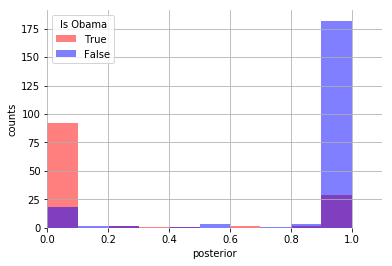

In [490]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [491]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Clinton,Clinton_log_prob,Obama,Obama_log_prob
0,dick,-1.791759,signature,-2.161173
1,amy,-1.802122,announcement,-2.290006
2,brundage,-1.900562,welcomed,-2.315324
3,chicago,-1.972021,ground,-2.395367
4,temporary,-2.117975,honor,-2.423538
5,location,-2.176816,opportunities,-2.423538
6,political,-2.223336,urban,-2.423538
7,va,-2.223336,entire,-2.437926
8,interests,-2.306027,growing,-2.437926
9,oversight,-2.306027,association,-2.467340


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [492]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [493]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [494]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: nltk.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

In [495]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [496]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [497]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [498]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [499]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.897852582704585


In [500]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
56,talk.religion.misc,talk.religion.misc
2101,comp.graphics,comp.graphics
1743,comp.graphics,comp.graphics
527,soc.religion.christian,soc.religion.christian
530,soc.religion.christian,soc.religion.christian
495,soc.religion.christian,soc.religion.christian
140,talk.religion.misc,soc.religion.christian
1952,comp.graphics,comp.graphics
865,soc.religion.christian,soc.religion.christian
1683,comp.graphics,comp.graphics


Looks pretty good, lets examine the testing dataset:

In [501]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.8069767441860465


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

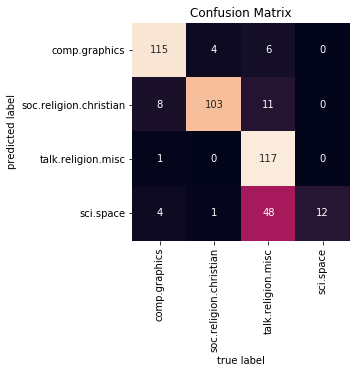

In [566]:
lucem_illud.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

In [567]:
MultinomialNB_ng

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [569]:
test_ng_df

,category,source_file,text,tokenized_text,normalized_text,vect,nb_predict
1862,comp.graphics,/Users/Reid/scikit_learn_data/20news_home/20ne...,\nAnother source: There's a poly blitter for ...,"[Another, source, :, There, 's, a, poly, blitt...","[anoth, sourc, poli, blitter, mode, mode, x, a...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",comp.graphics
391,soc.religion.christian,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\n\n >[I'm sort of mystified about how a Ch...,"[>, [, I, 'm, sort, of, mystified, about, how,...","[sort, mystifi, christian, might, respond, sta...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",soc.religion.christian
129,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\n\n\n\n\n\nIF it were'nt for the sin of men, ...","[IF, it, were'nt, for, the, sin, of, men, ,, n...","[sin, men, none, kill, would, necesarri, kind,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",soc.religion.christian
1192,sci.space,/Users/Reid/scikit_learn_data/20news_home/20ne...,Everbody has been defining envelope.\nWhy was ...,"[Everbody, has, been, defining, envelope, ., W...","[everbodi, defin, envelop, whi, world, envelop...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",soc.religion.christian
409,soc.religion.christian,/Users/Reid/scikit_learn_data/20news_home/20ne...,Hi I am a Sociology student and I am currently...,"[Hi, I, am, a, Sociology, student, and, I, am,...","[hi, sociolog, student, current, research, you...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",soc.religion.christian
253,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\nReplace ""Stephen"" with ""David Joslin,"" since...","[Replace, ``, Stephen, '', with, ``, David, Jo...","[replac, stephen, david, joslin, sinc, direct,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",talk.religion.misc
2036,comp.graphics,/Users/Reid/scikit_learn_data/20news_home/20ne...,\nTry FTP-ing at\n pub-info.jpl.nasa.gov (128...,"[Try, FTP-ing, at, pub-info.jpl.nasa.gov, (, 1...","[tri, simpl, sorri, onli, bit, gif, jpeg, grea...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",comp.graphics
701,soc.religion.christian,/Users/Reid/scikit_learn_data/20news_home/20ne...,This subject seems to be incredibly inflammato...,"[This, subject, seems, to, be, incredibly, inf...","[subject, seem, incred, inflammatori, subscrib...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",soc.religion.christian
1953,comp.graphics,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\n,[],[],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",soc.religion.christian
2045,comp.graphics,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\n\nLikewise for me please. First time I've ...,"[Likewise, for, me, please, ., First, time, I,...","[likewis, pleas, first, time, hear, beem, look...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",soc.religion.christian


Let's calculate the precision, recall, and F-measures.

In [503]:
print(sklearn.metrics.precision_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #F-1 measure

0.9107286967508863
0.8069767441860465
0.8344054206662902


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [504]:
lucem_illud.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
soc.religion.christian,0.891596,0.639735,0.153488,0.642857,0.991525
sci.space,0.914014,0.849362,0.055814,0.953704,0.844262
comp.graphics,0.938689,0.849818,0.053488,0.898438,0.920000
talk.religion.misc,0.592308,0.307871,0.123256,1.000000,0.184615


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

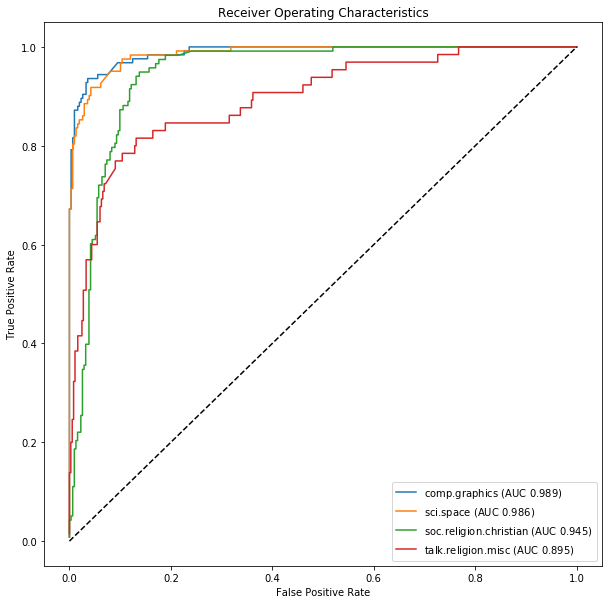

In [505]:
lucem_illud.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

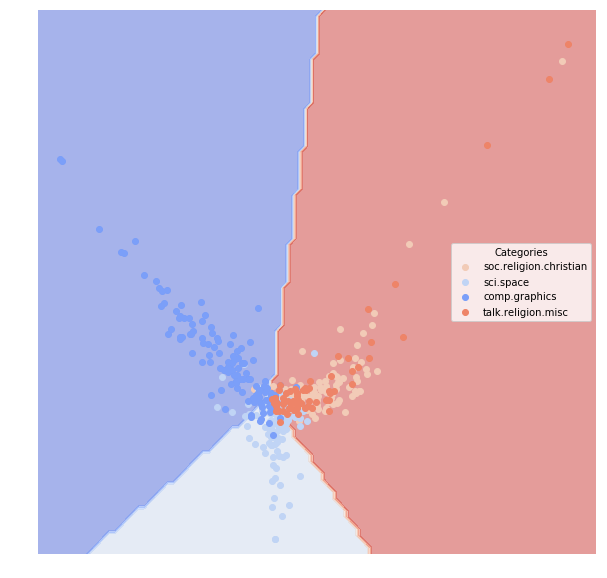

In [506]:
lucem_illud.plotregions(MultinomialNB_ng, test_ng_df)

We can also give the model a new string, not present in our data, and use the *predict* method to see if it can assign it to a category. Using our model to extend its classifications to new, uncoded data might be the primary purpose of a social science application. The words do have to be in the vocabulary, so don't be too creative :-)

In [507]:
def predict_category(s, model, tfidf): #We just define a simple function here
    a = np.zeros((1, len(tfidf.vocabulary_)))
    for w in nltk.word_tokenize(s):
        try:
            a[:,tfidf.vocabulary_[lucem_illud.stemmer_basic.stem(w.lower())]] = 1
        except KeyError:
            print("Warning: '{}' not in vocabulary".format(w))
    return model.predict(a)[0]

In [508]:
predict_category('rockets are cool', MultinomialNB_ng, TFVectorizer_ng)

'sci.space'

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [509]:
#using the coded data from mechanical turk week 5 ## whether or not the paragraph contains reference to 'social good'
clean = pandas.read_csv("C:\\Users\\Andrew\\content-analysis-2018\\content-analysis-2018\\5-Reliability\\clean.csv")

In [510]:
clean.head() #note I'll only be interested in worker 1's categorization for this study i.e. social1

,company,year,text,worker1,worker2,worker3,social1,social2,social3
0,CocaCola,2014,About half of these savings will come from bei...,A2CJFO19NY4T5R,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,1,0
1,Microsoft,2013,"As I think about whatâs ahead, Iâm incredi...",A3F0NFNLOLFJT0,A3IL3HGJW7K6Q1,A3RYI5HXC2MJLN,0,1,0
2,Microsoft,2016,Commercial cloud annualized revenue run rate e...,A2QLSHXNCHBRN4,A2WGW5Y3ZFBDEC,A3RYI5HXC2MJLN,0,0,0
3,McDonalds,2016,Customers noticed the changes we made. As of l...,A2CJFO19NY4T5R,A3BI0AX5T5GVO3,A3RYI5HXC2MJLN,0,0,0
4,CocaCola,2014,"Fact is, weâre competing in a historically s...",A3BI0AX5T5GVO3,AKSJ3C5O3V9RB,A166A2M31CW2C7,0,0,0


In [511]:
clean['tokenized_text'] = clean['text'].apply(lambda x: nltk.word_tokenize(x))
clean['normalized_text'] = clean['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

In [512]:
# split data 
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(clean, holdBackFraction=holdBackFraction)

In [513]:
#not a large data set, but will have to do for now.
print(len(train_data_df))
print(len(test_data_df))

47
11


## logistic regression 

In [572]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

In [573]:
TFVects.shape

(47, 274)

In [574]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In [575]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [576]:
train_data_df['pca'] = [r for r in reduced_data]

In [577]:
train_data_df.head()

,company,year,text,worker1,worker2,worker3,social1,social2,social3,tokenized_text,normalized_text,vect,pca,category,pca_reduced_10
40,McDonalds,2016,To continue growing the business for the long ...,A2WGW5Y3ZFBDEC,A3BI0AX5T5GVO3,A3RYI5HXC2MJLN,0,1,0,"[To, continue, growing, the, business, for, th...","[continu, grow, busi, long, term, need, grow, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0760009143047775, -0.2595534197393437, -0....",False,"[-0.0760009143047775, -0.2595534197393437, -0...."
27,Microsoft,2013,"Second, in September weÂ announcedÂ we are pur...",A2CJFO19NY4T5R,A2QLSHXNCHBRN4,A3RYI5HXC2MJLN,0,0,0,"[Second, ,, in, September, weÂ, announcedÂ, we...","[second, septemb, weâ, announcedâ, purchas, de...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.23661668251810464, 0.22566409579601615, -0....",False,"[0.23661668251810464, 0.22566409579601615, -0...."
48,Microsoft,2013,We have seen incredible results in the past de...,A1ZRK6K5JUPJAV,A2N7I0331X72Z7,A3RYI5HXC2MJLN,0,0,0,"[We, have, seen, incredible, results, in, the,...","[seen, incred, result, past, decad, deliv, bil...","[0.3171169372400548, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.14172607492085795, -0.1402078386702639, 0.1...",False,"[0.14172607492085795, -0.1402078386702639, 0.1..."
44,CocaCola,2015,We also announced that we expect to meet our g...,A2CJFO19NY4T5R,A2QLSHXNCHBRN4,A3RYI5HXC2MJLN,1,1,1,"[We, also, announced, that, we, expect, to, me...","[also, announc, expect, meet, goal, percent, w...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.04989070863905289, -0.2052388419514755, 0....",True,"[-0.04989070863905289, -0.2052388419514755, 0...."
38,McDonalds,2015,"Throughout 2015, we evaluated opportunities to...",A2LCFORIW0NF1S,A2QLSHXNCHBRN4,A3RYI5HXC2MJLN,0,0,0,"[Throughout, 2015, ,, we, evaluated, opportuni...","[throughout, evalu, opportun, drive, sharehold...","[0.0, 0.0, 0.2974262069866997, 0.1285766747842...","[-0.05542017265006749, -0.380638579350956, 0.1...",False,"[-0.05542017265006749, -0.380638579350956, 0.1..."


In [578]:

train_data_df['category'] = np.where(train_data_df['social1']==1, True, False)
train_data_df.head()

,company,year,text,worker1,worker2,worker3,social1,social2,social3,tokenized_text,normalized_text,vect,pca,category,pca_reduced_10
40,McDonalds,2016,To continue growing the business for the long ...,A2WGW5Y3ZFBDEC,A3BI0AX5T5GVO3,A3RYI5HXC2MJLN,0,1,0,"[To, continue, growing, the, business, for, th...","[continu, grow, busi, long, term, need, grow, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0760009143047775, -0.2595534197393437, -0....",False,"[-0.0760009143047775, -0.2595534197393437, -0...."
27,Microsoft,2013,"Second, in September weÂ announcedÂ we are pur...",A2CJFO19NY4T5R,A2QLSHXNCHBRN4,A3RYI5HXC2MJLN,0,0,0,"[Second, ,, in, September, weÂ, announcedÂ, we...","[second, septemb, weâ, announcedâ, purchas, de...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.23661668251810464, 0.22566409579601615, -0....",False,"[0.23661668251810464, 0.22566409579601615, -0...."
48,Microsoft,2013,We have seen incredible results in the past de...,A1ZRK6K5JUPJAV,A2N7I0331X72Z7,A3RYI5HXC2MJLN,0,0,0,"[We, have, seen, incredible, results, in, the,...","[seen, incred, result, past, decad, deliv, bil...","[0.3171169372400548, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.14172607492085795, -0.1402078386702639, 0.1...",False,"[0.14172607492085795, -0.1402078386702639, 0.1..."
44,CocaCola,2015,We also announced that we expect to meet our g...,A2CJFO19NY4T5R,A2QLSHXNCHBRN4,A3RYI5HXC2MJLN,1,1,1,"[We, also, announced, that, we, expect, to, me...","[also, announc, expect, meet, goal, percent, w...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.04989070863905289, -0.2052388419514755, 0....",True,"[-0.04989070863905289, -0.2052388419514755, 0...."
38,McDonalds,2015,"Throughout 2015, we evaluated opportunities to...",A2LCFORIW0NF1S,A2QLSHXNCHBRN4,A3RYI5HXC2MJLN,0,0,0,"[Throughout, 2015, ,, we, evaluated, opportuni...","[throughout, evalu, opportun, drive, sharehold...","[0.0, 0.0, 0.2974262069866997, 0.1285766747842...","[-0.05542017265006749, -0.380638579350956, 0.1...",False,"[-0.05542017265006749, -0.380638579350956, 0.1..."


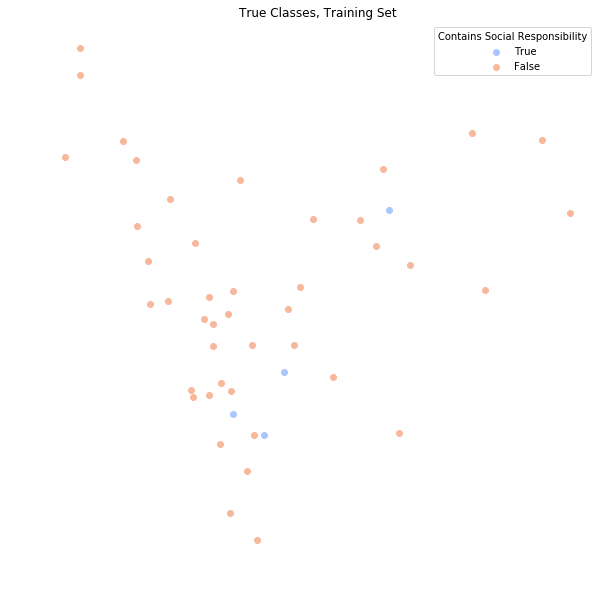

In [579]:
#Viz in 2D
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Social
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot No Social
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Contains Social Responsibility')
plt.title('True Classes, Training Set')
plt.show()
#note very sparse data with scattered social responsibility

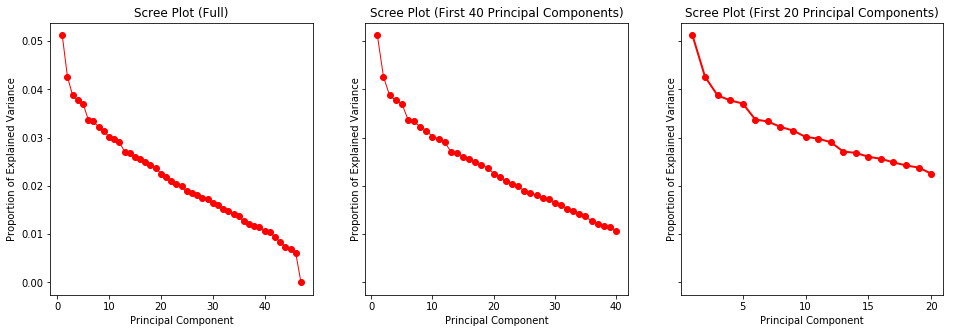

In [580]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(40) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:40], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 40 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 20 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [581]:
#use first 10 principal components
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

In [582]:
#fit regression
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [583]:
#performance on training data, likely overfits
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.9148936170212766

In [584]:
test_data_df['category'] = np.where(test_data_df['social1']==1, True, False)

In [585]:
#performance on all data
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])
#overfit due to small data sample

1.0

In [586]:
#use tf-idf
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9148936170212766


In [587]:
#train then test on all data
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))
#over fit, but likely better estimate

1.0


## Naive Bayes

In [592]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [593]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9361702127659575
Testing:
1.0


In [594]:
#note above: still overfit, let's show
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

In [595]:
#precision
sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['category'])

0.0

In [596]:
#recall
sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['category'])

0.0

In [597]:
#f1
sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['category'])

0.0

overall above indicates very poor performance, I blame the small amount of data gathered

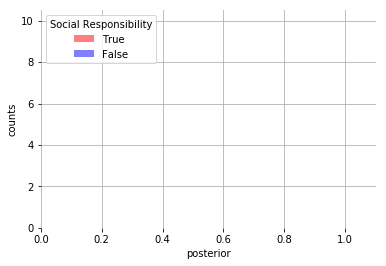

In [598]:
#posterior distributions
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Social Responsibility")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()
#embarrassing

In [599]:
#looking at word predictors
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Social' : [],
    'Social_log_prob' : [],
    'Not Social' : [],
    'None_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Not Social'].append(TFVectorizer.get_feature_names()[i])
    words_dict['None_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Social'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Social_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,None_log_prob,Not Social,Social,Social_log_prob
0,-1.167605,new,agency,-0.693147
1,-1.321756,weâ,areas,-0.693147
2,-1.408767,growth,business,-0.693147
3,-1.504077,billion,day,-0.693147
4,-1.504077,world,focus,-0.693147
5,-1.609438,business,water,-0.693147
6,-1.609438,customers,wellâ,-0.693147
7,-1.609438,including,year,-0.693147
8,-1.609438,partners,activities,-1.098612
9,-1.609438,year,ahead,-1.098612


The above chart demonstrates the clear overfitting of the model. VMany of the words in the social category are truly common words in all the documents.

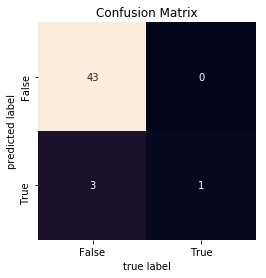

In [571]:
lucem_illud.plotConfusionMatrix()

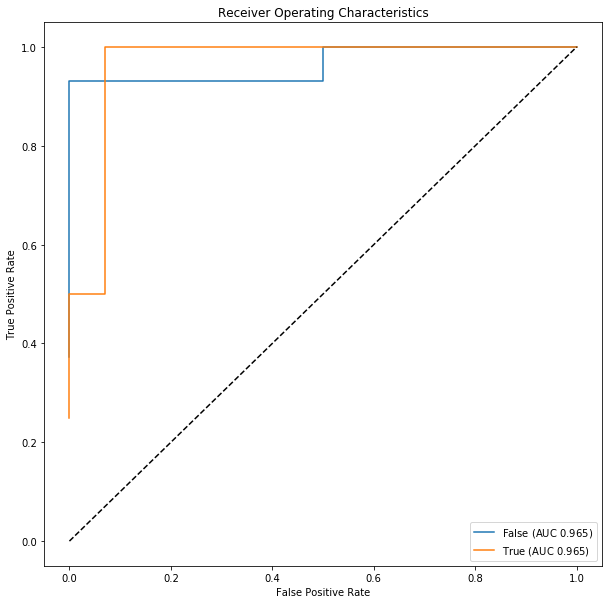

In [600]:
lucem_illud.plotMultiROC( naiveBayes, train_data_df)
#very little false positive

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

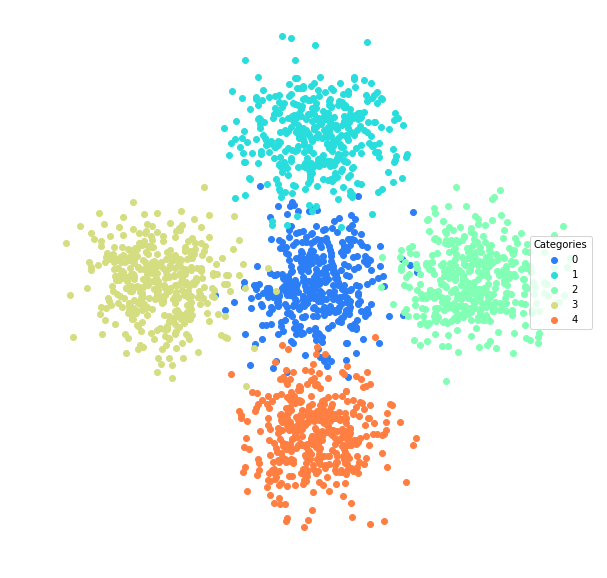

In [601]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud.trainTestSplit(blobs_df)
lucem_illud.plotter(df_exampleTree_train)

In [616]:
df_exampleTree_train.head()

,category,vect
699,2,"[3.866338066204684, -1.0015472838498864]"
822,4,"[0.5263842152666249, -4.0303304348583415]"
841,1,"[1.0556235875792417, 5.204944799942303]"
867,4,"[-0.2388140647756932, -4.646229982436102]"
599,1,"[1.2641663565383243, 5.61437877498743]"


Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [602]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

To see what's going on visually with the classification: 

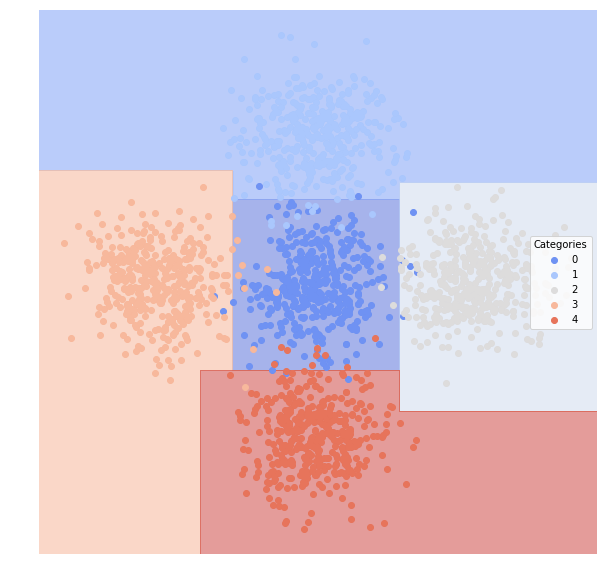

In [603]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [604]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.970761,0.872286,0.028,0.894231,0.968750
1,0.985201,0.970047,0.008,0.990826,0.972973
2,0.983146,0.972292,0.006,1.000000,0.966292
3,0.993930,0.982862,0.004,0.990385,0.990385
4,0.978750,0.958103,0.010,0.989691,0.960000


Lets look at accuracy:

In [605]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.972

What happens if we trim the tree?

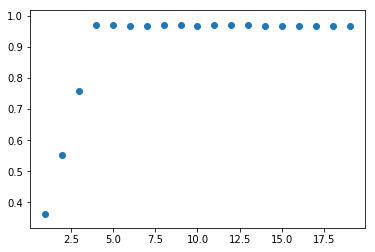

In [606]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [607]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [608]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

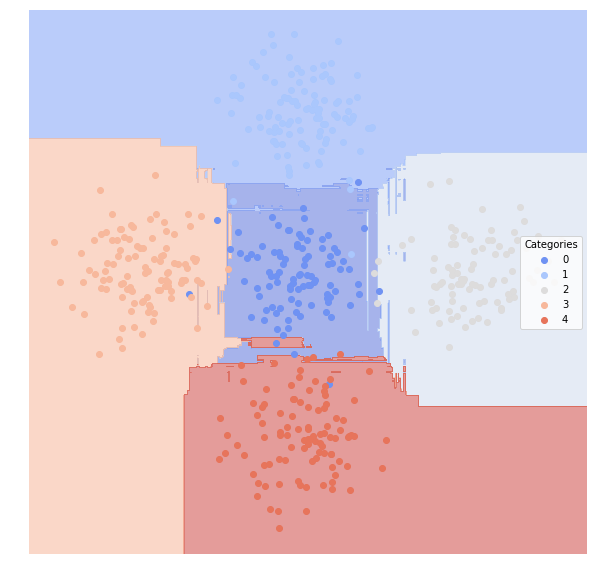

In [609]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [610]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.949928,0.839104,0.036,0.890000,0.927083
1,0.980697,0.963038,0.010,0.990741,0.963964
2,0.987547,0.970420,0.006,0.988636,0.977528
3,0.986597,0.956747,0.010,0.971429,0.980769
4,0.982500,0.956404,0.010,0.979798,0.970000


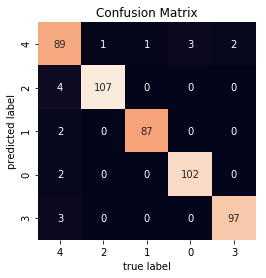

In [611]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

Ensemble learning gathers multiple learning algorithms to solve the same problem. In the random forest algorithm, many decision trees are 'bagged' to make the classification algorithm more accurate. These classifiers perform well generally, but my data has too few "True" tags indicating social responsibility and too few observations to generate a clear signal.

In [628]:
clean['category'] = np.where(clean['social1']==1, True, False)
TFVects = TFVectorizer.transform(clean['text'])
clean['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
# split data 
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(clean, holdBackFraction=holdBackFraction)

In [629]:
clean.head()

,company,year,text,worker1,worker2,worker3,social1,social2,social3,tokenized_text,normalized_text,category,vect
0,CocaCola,2014,About half of these savings will come from bei...,A2CJFO19NY4T5R,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,1,0,"[About, half, of, these, savings, will, come, ...","[half, save, come, effici, way, make, distribu...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Microsoft,2013,"As I think about whatâs ahead, Iâm incredi...",A3F0NFNLOLFJT0,A3IL3HGJW7K6Q1,A3RYI5HXC2MJLN,0,1,0,"[As, I, think, about, whatâs, ahead, ,, Iâ...","[think, ahead, incred, optimist, microsoft, de...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.163..."
2,Microsoft,2016,Commercial cloud annualized revenue run rate e...,A2QLSHXNCHBRN4,A2WGW5Y3ZFBDEC,A3RYI5HXC2MJLN,0,0,0,"[Commercial, cloud, annualized, revenue, run, ...","[commerci, cloud, annual, revenu, run, rate, e...",False,"[0.0, 0.11738701431353951, 0.0, 0.0, 0.0, 0.0,..."
3,McDonalds,2016,Customers noticed the changes we made. As of l...,A2CJFO19NY4T5R,A3BI0AX5T5GVO3,A3RYI5HXC2MJLN,0,0,0,"[Customers, noticed, the, changes, we, made, ....","[custom, notic, chang, made, late, seven, ten,...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.38208934875799505,..."
4,CocaCola,2014,"Fact is, weâre competing in a historically s...",A3BI0AX5T5GVO3,AKSJ3C5O3V9RB,A166A2M31CW2C7,0,0,0,"[Fact, is, ,, weâre, competing, in, a, histo...","[fact, compet, histor, strong, grow, marketpla...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [630]:
train_data_df.head()

,company,year,text,worker1,worker2,worker3,social1,social2,social3,tokenized_text,normalized_text,category,vect
45,McDonalds,2015,We are in a stronger position today than we we...,A2WGW5Y3ZFBDEC,A3F0NFNLOLFJT0,A3RYI5HXC2MJLN,0,0,0,"[We, are, in, a, stronger, position, today, th...","[stronger, posit, today, twelv, month, ago, fo...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27,Microsoft,2013,"Second, in September weÂ announcedÂ we are pur...",A2CJFO19NY4T5R,A2QLSHXNCHBRN4,A3RYI5HXC2MJLN,0,0,0,"[Second, ,, in, September, weÂ, announcedÂ, we...","[second, septemb, weâ, announcedâ, purchas, de...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,McDonalds,2016,Last month marked two years since I stepped in...,A2CJFO19NY4T5R,A3BI0AX5T5GVO3,A3RYI5HXC2MJLN,0,0,0,"[Last, month, marked, two, years, since, I, st...","[last, month, mark, two, year, sinc, step, ceo...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,CocaCola,2014,"Fourth,Â we aggressively stepped up ourÂ produ...",A3BI0AX5T5GVO3,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,0,0,"[Fourth, ,, Â, we, aggressively, stepped, up, ...","[fourth, â, aggress, step, ourâ, product, alre...",False,"[0.0, 0.0, 0.0, 0.29271874247898455, 0.0, 0.0,..."
21,Microsoft,2016,Office 365 is changing the nature of work for ...,A2CJFO19NY4T5R,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,0,0,"[Office, 365, is, changing, the, nature, of, w...","[offic, chang, natur, work, individu, team, cu...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.291..."


In [631]:
#note: binary classifier
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

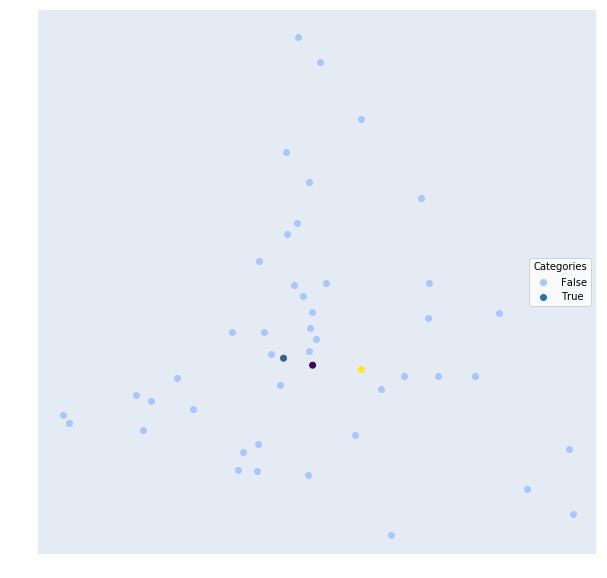

In [632]:
lucem_illud.plotregions(clf_tree, train_data_df)

In [633]:
lucem_illud.evaluateClassifier(clf_tree, test_data_df)

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
False,0.5,0.909091,0.090909,0.909091,1.0
True,0.5,0.090909,0.090909,0.000000,0.0


In [634]:
sklearn.metrics.accuracy_score(test_data_df['category'],clf_tree.predict(np.stack(test_data_df['vect'], axis = 0)))

0.9090909090909091

## Random Forest

In [636]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [637]:
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

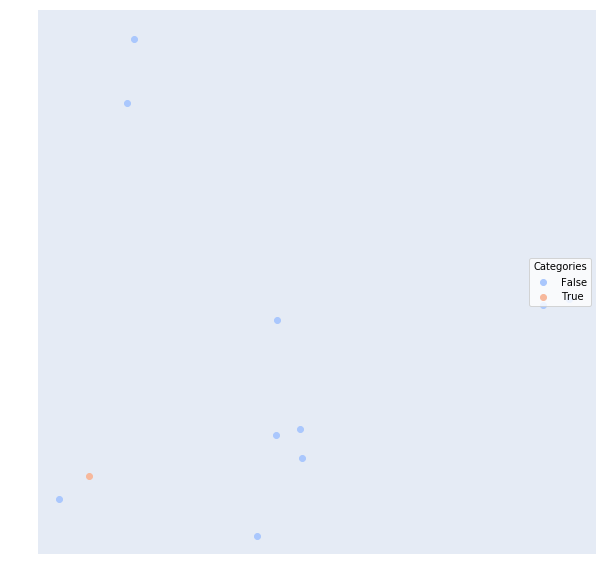

In [638]:
lucem_illud.plotregions(bag, test_data_df)

In [639]:
lucem_illud.evaluateClassifier(bag, test_data_df)

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
False,0.5,0.909091,0.090909,0.909091,1.0
True,0.5,0.090909,0.090909,0.000000,0.0


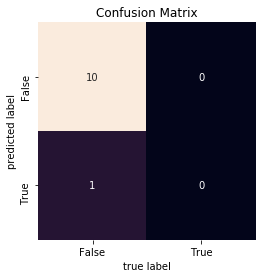

In [707]:
lucem_illud.plotConfusionMatrix(bag, test_data_df)

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [642]:
newsgroupsDF[:5]

,category,source_file,text,tokenized_text,normalized_text
0,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\nParadise and salvation are not the same th...,"[Paradise, and, salvation, are, not, the, same...","[paradis, salvat, thing, salvat, better, refer..."
1,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,\nYou're admitting a lot more than that. You ...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situat, admit, acti..."
2,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\n\nJesus also recognized other holy days, lik...","[Jesus, also, recognized, other, holy, days, ,...","[jesus, also, recogn, holi, day, like, passov,..."
3,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,"[In, <, lsjc8cINNmc1, @, saltillo.cs.utexas.ed...","[turpin, russel, turpin, regard, love, less, b..."
4,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\nI'm sorry, but He does not! Ever read the F...","[I, 'm, sorry, ,, but, He, does, not, !, Ever,...","[sorri, doe, ever, read, first, command]"


Make a testing and training set:

In [643]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [644]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [645]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [646]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [647]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
soc.religion.christian,0.523760,0.315077,0.267557,1.000000,0.047521
sci.space,0.675144,0.448960,0.213581,0.681208,0.426471
comp.graphics,0.707832,0.414148,0.302380,0.466125,0.730361
talk.religion.misc,0.620551,0.221040,0.356355,0.257530,0.585616


And lets look at the testing data

In [648]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.2627906976744186


Let's produce another confusion matrix:

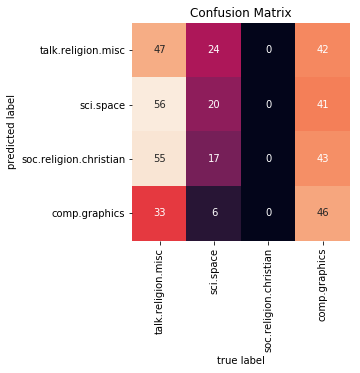

In [649]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [650]:
lucem_illud.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

K-nearest neighbor is similar to k-means clustering explored in week 3. K-nearest neighbor identifies the class of nearby datapoints and chooses the classification for the local datapoint based on those neighbor's classification.

In [667]:
clean

,company,year,text,worker1,worker2,worker3,social1,social2,social3,tokenized_text,normalized_text,category,vect
0,CocaCola,2014,About half of these savings will come from bei...,A2CJFO19NY4T5R,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,1,0,"[About, half, of, these, savings, will, come, ...","[half, save, come, effici, way, make, distribu...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Microsoft,2013,"As I think about whatâs ahead, Iâm incredi...",A3F0NFNLOLFJT0,A3IL3HGJW7K6Q1,A3RYI5HXC2MJLN,0,1,0,"[As, I, think, about, whatâs, ahead, ,, Iâ...","[think, ahead, incred, optimist, microsoft, de...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.163..."
2,Microsoft,2016,Commercial cloud annualized revenue run rate e...,A2QLSHXNCHBRN4,A2WGW5Y3ZFBDEC,A3RYI5HXC2MJLN,0,0,0,"[Commercial, cloud, annualized, revenue, run, ...","[commerci, cloud, annual, revenu, run, rate, e...",False,"[0.0, 0.11738701431353951, 0.0, 0.0, 0.0, 0.0,..."
3,McDonalds,2016,Customers noticed the changes we made. As of l...,A2CJFO19NY4T5R,A3BI0AX5T5GVO3,A3RYI5HXC2MJLN,0,0,0,"[Customers, noticed, the, changes, we, made, ....","[custom, notic, chang, made, late, seven, ten,...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.38208934875799505,..."
4,CocaCola,2014,"Fact is, weâre competing in a historically s...",A3BI0AX5T5GVO3,AKSJ3C5O3V9RB,A166A2M31CW2C7,0,0,0,"[Fact, is, ,, weâre, competing, in, a, histo...","[fact, compet, histor, strong, grow, marketpla...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,CocaCola,2014,"Fifth,Â we beganÂ streamlining and simplifying...",A2CJFO19NY4T5R,A3BL2ZEODD79AZ,A3RYI5HXC2MJLN,0,1,0,"[Fifth, ,, Â, we, beganÂ, streamlining, and, s...","[fifth, â, beganâ, streamlin, simplifi, oper, ...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,Microsoft,2013,"First, we are well underway in implementing th...",A1APYLD4DUK33J,A2CJFO19NY4T5R,A3RYI5HXC2MJLN,0,0,0,"[First, ,, we, are, well, underway, in, implem...","[first, well, underway, implement, new, organ,...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,CocaCola,2015,"First, we said we would establishÂ clear portf...",A2WGW5Y3ZFBDEC,AOHE56L0POV6,A8TIL9U6YHG5,0,0,1,"[First, ,, we, said, we, would, establishÂ, cl...","[first, said, would, establishâ, clear, portfo...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,CocaCola,2014,"First,Â we are makingÂ targeted, disciplined i...",A2WGW5Y3ZFBDEC,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,0,0,"[First, ,, Â, we, are, makingÂ, targeted, ,, d...","[first, â, makingâ, target, disciplin, investm...",False,"[0.0, 0.0, 0.0, 0.2665345358174904, 0.0, 0.0, ..."
9,CocaCola,2014,"Fourth,Â we aggressively stepped up ourÂ produ...",A3BI0AX5T5GVO3,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,0,0,"[Fourth, ,, Â, we, aggressively, stepped, up, ...","[fourth, â, aggress, step, ourâ, product, alre...",False,"[0.0, 0.0, 0.0, 0.29271874247898455, 0.0, 0.0,..."


In [668]:
holdBackFraction = .2
train, test = lucem_illud.trainTestSplit(clean, holdBackFraction=holdBackFraction)

In [669]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [670]:
train

,company,year,text,worker1,worker2,worker3,social1,social2,social3,tokenized_text,normalized_text,category,vect
50,McDonalds,2015,We recommitted to running great restaurants an...,A2CJFO19NY4T5R,A3BI0AX5T5GVO3,A292QSLC0BUT0O,0,1,1,"[We, recommitted, to, running, great, restaura...","[recommit, run, great, restaur, deliv, custom,...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17,Microsoft,2013,Last year in my letter to you I declared a fun...,A2CJFO19NY4T5R,A3BI0AX5T5GVO3,A3RYI5HXC2MJLN,0,0,0,"[Last, year, in, my, letter, to, you, I, decla...","[last, year, letter, declar, fundament, shift,...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
27,Microsoft,2013,"Second, in September weÂ announcedÂ we are pur...",A2CJFO19NY4T5R,A2QLSHXNCHBRN4,A3RYI5HXC2MJLN,0,0,0,"[Second, ,, in, September, weÂ, announcedÂ, we...","[second, septemb, weâ, announcedâ, purchas, de...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Microsoft,2013,"As I think about whatâs ahead, Iâm incredi...",A3F0NFNLOLFJT0,A3IL3HGJW7K6Q1,A3RYI5HXC2MJLN,0,1,0,"[As, I, think, about, whatâs, ahead, ,, Iâ...","[think, ahead, incred, optimist, microsoft, de...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.163..."
11,McDonalds,2016,"In addition, we will return $22-24 billion to ...",A2WGW5Y3ZFBDEC,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,0,0,"[In, addition, ,, we, will, return, $, 22-24, ...","[addit, return, billion, sharehold, period, lo...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2138116561588..."
31,CocaCola,2015,Sustainability.Â We advanced our sustainabilit...,A2QLSHXNCHBRN4,AKSJ3C5O3V9RB,A8TIL9U6YHG5,1,1,1,"[Sustainability.Â, We, advanced, our, sustaina...","[advanc, sustain, partnership, across, three, ...",True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22,McDonalds,2016,"On digital, weâre re-shaping customer intera...",AKSJ3C5O3V9RB,A3BI0AX5T5GVO3,ATHS9CW2FLYUY,0,1,0,"[On, digital, ,, weâre, re-shaping, customer...","[digit, custom, interact, energis, exist, serv...",False,"[0.18269433921435663, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,CocaCola,2014,"Fact is, weâre competing in a historically s...",A3BI0AX5T5GVO3,AKSJ3C5O3V9RB,A166A2M31CW2C7,0,0,0,"[Fact, is, ,, weâre, competing, in, a, histo...","[fact, compet, histor, strong, grow, marketpla...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,CocaCola,2014,"Fourth,Â we aggressively stepped up ourÂ produ...",A3BI0AX5T5GVO3,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,0,0,"[Fourth, ,, Â, we, aggressively, stepped, up, ...","[fourth, â, aggress, step, ourâ, product, alre...",False,"[0.0, 0.0, 0.0, 0.29271874247898455, 0.0, 0.0,..."
30,McDonalds,2016,Stronger customer perceptions of McDonaldâs ...,A3BI0AX5T5GVO3,AKSJ3C5O3V9RB,A3RYI5HXC2MJLN,0,0,0,"[Stronger, customer, perceptions, of, McDonald...","[stronger, custom, percept, help, drive, stron...",False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.17521327926837604,..."


In [677]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train['text'])
train['vect'] =  [np.array(v).flatten() for v in TFVects.todense()]

In [678]:
clf_knearest.fit(np.stack(train['vect'], axis = 0), train['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [680]:
lucem_illud.evaluateClassifier(clf_knearest, train)

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
False,0.5,0.914894,0.085106,0.914894,1.0
True,0.5,0.085106,0.085106,0.000000,0.0


In [681]:
#Create vectors
TFVects_test = TFVectorizer.transform(test['text'])
test['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test['nb_predict'] = clf_knearest.predict(np.stack(test['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test['vect'], axis=0), test['category']))

Testing score:
1.0


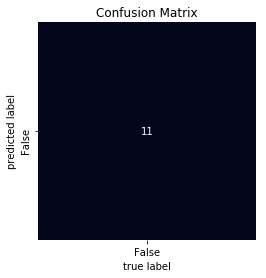

In [704]:
lucem_illud.plotConfusionMatrix(clf_knearest, test)

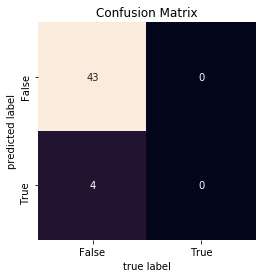

In [706]:
lucem_illud.plotConfusionMatrix(clf_knearest, train)

In [ ]:
#visualization
lucem_illud.plotregions(clf_knearest, test)

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [684]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: nltk.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

We will tf.idf the data to make our vectors:

In [685]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [686]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [687]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

...and consider the results:

In [688]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Relationships,0.979018,0.905734,0.025078,0.914634,0.986842
Weeaboo Tales: stories about the extreme fans of japanese culture,0.982353,0.974110,0.009404,1.000000,0.964706
Tales From Tech Support,0.993902,0.990940,0.003135,1.000000,0.987805
Bad Roommates: Tales of Irritation,0.969569,0.934303,0.018809,0.972973,0.947368


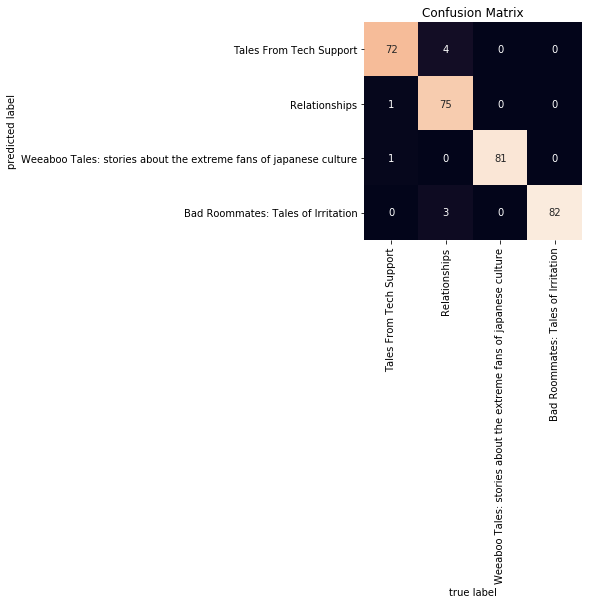

In [689]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

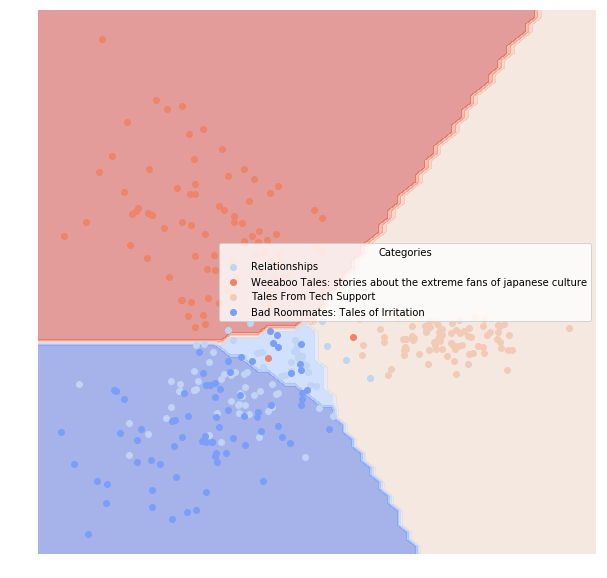

In [690]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [691]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [692]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Relationships,0.956817,0.888423,0.031348,0.934211,0.934211
Weeaboo Tales: stories about the extreme fans of japanese culture,0.980216,0.962487,0.012539,0.987952,0.964706
Tales From Tech Support,1.000000,1.000000,0.000000,1.000000,1.000000
Bad Roommates: Tales of Irritation,0.969975,0.908359,0.025078,0.935897,0.960526


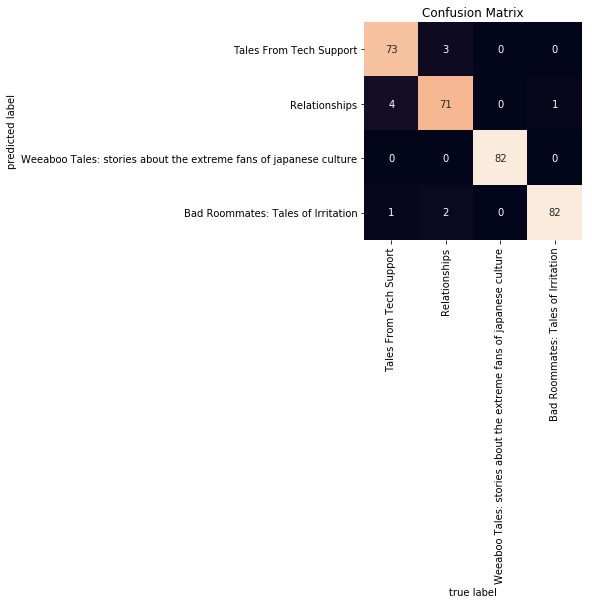

In [693]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

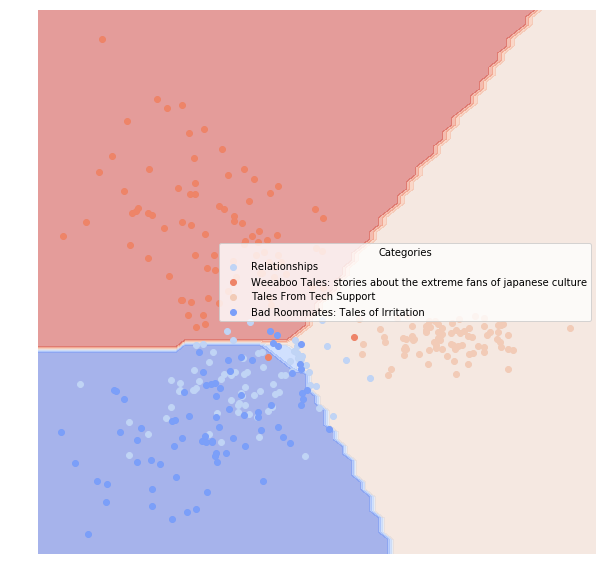

In [694]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

The neural network performs very poorly for my dataset, along with the other classification methods. However, looking at the reddit data provided as an example, it performed very well. This classification works by updating our priors with a hidden layer, which provides a clearer signal. This additional network (which k-nearest, naive bayes, logistic regression, and decision-tree algorithms do not have) updates the weights on each input variable to better classify the datapoint.

In [695]:
clf_nn.fit(np.stack(train['vect'], axis=0), train['category'])

c:\users\andrew\appdata\local\programs\python\python36\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [710]:
test['nb_predict'] = clf_nn.predict(np.stack(test['vect'], axis=0))
#note: No AUC because the out variable is binary

In [711]:
#precision
sklearn.metrics.precision_score(test['nb_predict'], test['category'])

0.0

In [712]:
#recall
sklearn.metrics.recall_score(test['nb_predict'], test['category'])

0.0

In [713]:
#f1 measure
sklearn.metrics.f1_score(test['nb_predict'], test['category'])

0.0

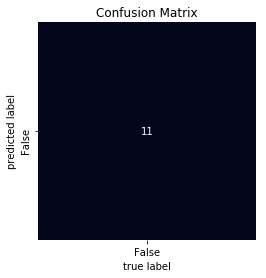

In [700]:
lucem_illud.plotConfusionMatrix(clf_nn, test)

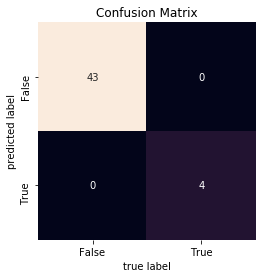

In [703]:
lucem_illud.plotConfusionMatrix(clf_nn, train)

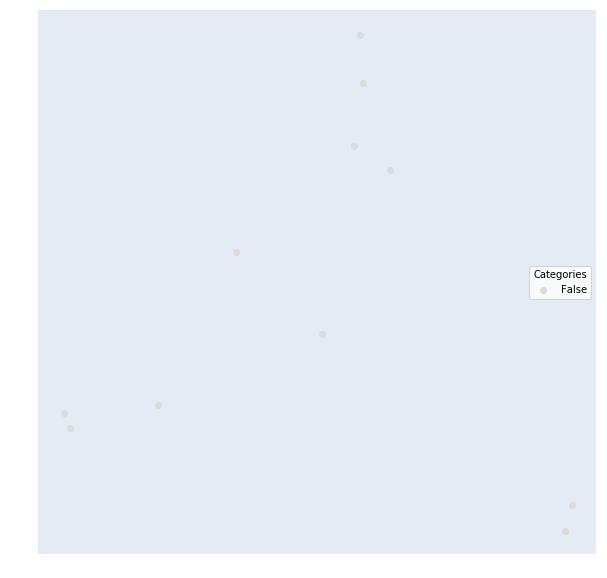

In [701]:
lucem_illud.plotregions(clf_nn, test)

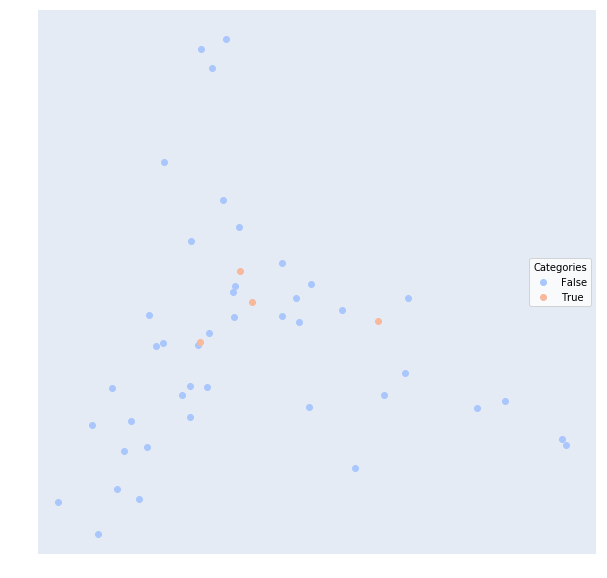

In [702]:
lucem_illud.plotregions(clf_nn, train)

In [ ]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))